# Credits
> This code is a slight modification to a translation (TensorFlow --> PyTorch) of a previous version of the [02456](http://kurser.dtu.dk/course/02456) course material. 
> [Original repo link (TensorFlow)](https://github.com/DeepLearningDTU/02456-deep-learning).
> [Translated repo link (PyTorch)](https://github.com/munkai/pytorch-tutorial/tree/master/2_intermediate).

In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

![MNIST.Exampel](../static_files/mnist.png)


## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [2]:
#get -N https://github.com/maximai/placeholder_repo/raw/master/mnist.npz;

In [3]:
#To speed up training we'll only work on a subset of the data
data = np.load('mnist.npz')
num_classes = 10
x_train = data['X_train'][:1000].astype('float32')
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
targets_test = data['y_test'][:500].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train (1000, 784)
targets_train (1000,)
x_valid (500, 784)
targets_valid (500,)
x_test (500, 784)
targets_test (500,)


In [4]:
data

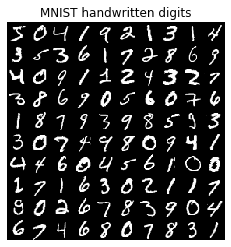

In [5]:
#plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Model

One of the large challenges in deep learning is the amount of hyperparameters that needs to be selected, and the lack of a good principled way of selecting them.
Hyperparameters can be found by experience (guessing) or some search procedure (often quite slow).
Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [Spearmint](https://github.com/JasperSnoek/spearmint) and many others.

**In practice a lot of trial and error is almost always involved.** This can be frustrating and time consuming, but the best thing to do is to think as a scientist, and go about it in a ordered manner --> monitor as much as you can, take notes, and be deliberate!

Below are some guidelines that you can use as a starting point to some of the most important hyperparameters. 
(*regularization* is also very important, but will be covered later.)


### Ballpark estimates of hyperparameters
__Number of hidden units and network structure:__
You'll have to experiment. One rarely goes below 512 units for feedforward networks (unless your are training on CPU...).
There's some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Parameter initialization:__
Parameter initialization is extremely important.
PyTorch has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaming He
2. Xavier Glorot
3. Uniform or Normal with small scale (0.1 - 0.01)
4. Orthogonal (this usually works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Mini-batch size:__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory, which means you can train a model with more parameters.

__Nonlinearity:__ [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
1. ReLU
2. Leaky ReLU
3. Elu
3. Sigmoid squash the output [0, 1], and are used if your output is binary (not used in the hidden layers)
4. Tanh is similar to sigmoid, but squashes in [-1, 1]. It is rarely used any more.
4. Softmax normalizes the the output to 1, and is used as output if you have a classification problem

See the plot below.

__Optimizer and learning rate:__
1. SGD + Momentum: learning rate 1.0 - 0.1 
2. ADAM: learning rate 3*1e-4 - 1e-5
3. RMSPROP: somewhere between SGD and ADAM


softmax should sum to one (approxiamtely): 1.0


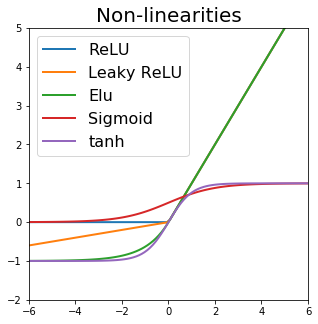

In [6]:
# Illustrate different output units
x = np.linspace(-6, 6, 100)
units = {
    "ReLU": lambda x: np.maximum(0, x),
    "Leaky ReLU": lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x),
    "Elu": lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1),
    "Sigmoid": lambda x: (1 + np.exp(-x))**(-1),
    "tanh": lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# assert that all class probablities sum to one
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))
print("softmax should sum to one (approxiamtely):", np.sum(softmax(x)))

In [7]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output,weightinit):
        super(Net, self).__init__()  
        # input layer
        if(weightinit == 'xavier'):
            self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        else:
            self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        self.activation = torch.nn.ELU()
        

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        return F.softmax(x, dim=1)


net = Net(num_features, num_l1, num_classes,'none')

In [8]:
optimizer = optim.SGD(net.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

In [9]:
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())

torch.Size([45, 10])


# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

In [10]:
# we could have done this ourselves,
# but we should be aware of sklearn and it's tools
from sklearn.metrics import accuracy_score

def training_loop(optimizer,num_epochs):
# setting hyperparameters and gettings epoch sizes
    batch_size = 100
    num_samples_train = x_train.shape[0]
    num_batches_train = num_samples_train // batch_size
    num_samples_valid = x_valid.shape[0]
    num_batches_valid = num_samples_valid // batch_size

    # setting up lists for handling loss/accuracy
    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    test_acc, test_loss = [], []
    cur_loss = 0
    losses = []

    get_slice = lambda i, size: range(i * size, (i + 1) * size)

    for epoch in range(num_epochs):
        # Forward -> Backprob -> Update params
        ## Train
        cur_loss = 0
        net.train()
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_train[slce]))
            output = net(x_batch)

            # compute gradients given loss
            target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
            batch_loss = criterion(output, target_batch)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            cur_loss += batch_loss   
        losses.append(cur_loss / batch_size)

        net.eval()
        ### Evaluate training
        train_preds, train_targs = [], []
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_train[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]

            train_targs += list(targets_train[slce])
            train_preds += list(preds.data.numpy())

        ### Evaluate validation
        val_preds, val_targs = [], []
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]
            val_preds += list(preds.data.numpy())
            val_targs += list(targets_valid[slce])

        train_acc_cur = accuracy_score(train_targs, train_preds)
        valid_acc_cur = accuracy_score(val_targs, val_preds)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)

        if epoch % 50 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                    epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

    epoch = np.arange(len(train_acc))
    plt.figure()
    plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('Updates'), plt.ylabel('Acc')

# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on cleaver use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay) 
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code)
- add batchnorm

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    

torch.Size([45, 10])
Epoch  1 : Train Loss 0.227910 , Train acc 0.338000, Valid acc 0.326000
Epoch 51 : Train Loss 0.157888 , Train acc 0.929000, Valid acc 0.814000
Epoch 101 : Train Loss 0.153202 , Train acc 0.957000, Valid acc 0.826000
Epoch 151 : Train Loss 0.151227 , Train acc 0.967000, Valid acc 0.828000
Epoch 201 : Train Loss 0.150230 , Train acc 0.971000, Valid acc 0.834000
Epoch 251 : Train Loss 0.149558 , Train acc 0.975000, Valid acc 0.836000
Epoch 301 : Train Loss 0.149082 , Train acc 0.978000, Valid acc 0.834000
Epoch 351 : Train Loss 0.148846 , Train acc 0.978000, Valid acc 0.830000


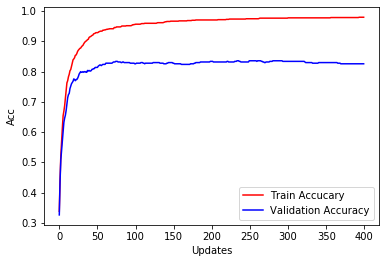

In [11]:
# Running the scripts using Kaiming He Initalization
net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.SGD(net.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())
training_loop(optimizer,400)

torch.Size([45, 1024])
Epoch  1 : Train Loss 0.693152 , Train acc 0.000000, Valid acc 0.000000
Epoch 51 : Train Loss 0.690848 , Train acc 0.097000, Valid acc 0.106000
Epoch 101 : Train Loss 0.672597 , Train acc 0.213000, Valid acc 0.210000
Epoch 151 : Train Loss 0.671864 , Train acc 0.213000, Valid acc 0.210000
Epoch 201 : Train Loss 0.661805 , Train acc 0.317000, Valid acc 0.298000
Epoch 251 : Train Loss 0.661689 , Train acc 0.317000, Valid acc 0.300000
Epoch 301 : Train Loss 0.661649 , Train acc 0.317000, Valid acc 0.300000
Epoch 351 : Train Loss 0.661563 , Train acc 0.318000, Valid acc 0.300000


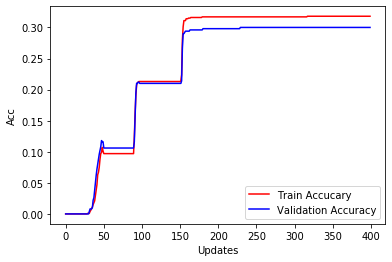

In [12]:
# Using three layers

#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net_3(nn.Module):

    def __init__(self, num_features, num_hidden,num_hidden_2, num_output,weightinit):
        super(Net_3, self).__init__()  
        # input layer
        if(weightinit == 'xavier'):
            self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        else:
            self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden_2, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden_2), 0))
            self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden_2)))
            self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
            
        self.activation = torch.nn.ELU()
        
        

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        F.linear(x,self.W_3,self.b_3)
        return F.softmax(x, dim=1)
    
net = Net_3(num_features, num_l1, 1024, num_classes,'none')
optimizer = optim.SGD(net.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')
print(net(Variable(torch.from_numpy(x))).size())
t = time.time()
training_loop(optimizer,400)
elapsed = time.time() - t
print("Training time: " + elapsed)

Comparing the convergence rate of the two neural networks shows that the advanced network takes much longer to train,
because of the much larger parameter space.
Now we will consider the 1 hidden-layer model with a different activation function

torch.Size([45, 10])
Epoch  1 : Train Loss 0.230283 , Train acc 0.152000, Valid acc 0.124000
Epoch 51 : Train Loss 0.158432 , Train acc 0.932000, Valid acc 0.826000
Epoch 101 : Train Loss 0.153007 , Train acc 0.957000, Valid acc 0.830000
Epoch 151 : Train Loss 0.150946 , Train acc 0.968000, Valid acc 0.840000
Epoch 201 : Train Loss 0.150033 , Train acc 0.971000, Valid acc 0.850000
Epoch 251 : Train Loss 0.149351 , Train acc 0.976000, Valid acc 0.842000
Epoch 301 : Train Loss 0.149054 , Train acc 0.977000, Valid acc 0.850000
Epoch 351 : Train Loss 0.148814 , Train acc 0.978000, Valid acc 0.848000


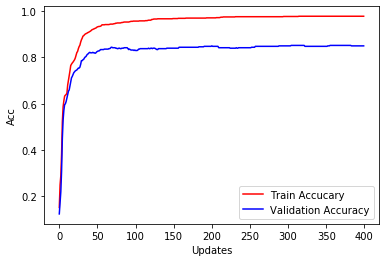

In [13]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output,weightinit):
        super(Net, self).__init__()  
        # input layer
        if(weightinit == 'xavier'):
            self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        else:
            self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        return F.softmax(x, dim=1)


net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.SGD(net.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())
training_loop(optimizer,400)

Both the validation and training accuracy has increased slightly comparing it to before. Do note that the initial weights are not the same, so a complete 1 to 1 comparison is not fair.

We will now optimze using a momentum in the gradient, using the ReLU activation function



torch.Size([45, 10])
Epoch  1 : Train Loss 0.226362 , Train acc 0.398000, Valid acc 0.356000
Epoch 51 : Train Loss 0.148300 , Train acc 0.981000, Valid acc 0.848000
Epoch 101 : Train Loss 0.147901 , Train acc 0.983000, Valid acc 0.844000
Epoch 151 : Train Loss 0.147759 , Train acc 0.984000, Valid acc 0.848000
Epoch 201 : Train Loss 0.147730 , Train acc 0.984000, Valid acc 0.850000
Epoch 251 : Train Loss 0.147717 , Train acc 0.984000, Valid acc 0.854000
Epoch 301 : Train Loss 0.147710 , Train acc 0.984000, Valid acc 0.854000
Epoch 351 : Train Loss 0.147704 , Train acc 0.984000, Valid acc 0.854000


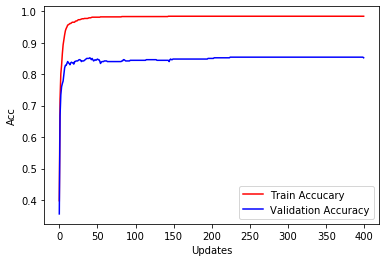

In [14]:
net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.9)
criterion = nn.CrossEntropyLoss()
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())
training_loop(optimizer,400)


torch.Size([45, 10])
Epoch  1 : Train Loss 0.229591 , Train acc 0.207000, Valid acc 0.222000
Epoch 51 : Train Loss 0.157068 , Train acc 0.940000, Valid acc 0.826000
Epoch 101 : Train Loss 0.151537 , Train acc 0.964000, Valid acc 0.850000
Epoch 151 : Train Loss 0.149898 , Train acc 0.973000, Valid acc 0.838000
Epoch 201 : Train Loss 0.149277 , Train acc 0.975000, Valid acc 0.840000
Epoch 251 : Train Loss 0.148943 , Train acc 0.976000, Valid acc 0.836000
Epoch 301 : Train Loss 0.148775 , Train acc 0.977000, Valid acc 0.838000
Epoch 351 : Train Loss 0.148658 , Train acc 0.977000, Valid acc 0.838000


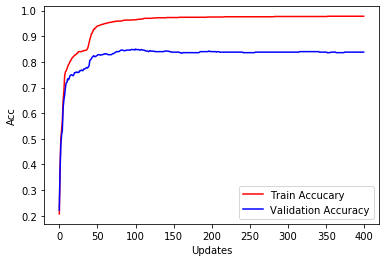

In [15]:
net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.3)
criterion = nn.CrossEntropyLoss()
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())
training_loop(optimizer,400)

Much faster convergence can be seen when using the momentum. Finally the ADAM optimzer will be used

torch.Size([45, 10])
Epoch  1 : Train Loss 0.226897 , Train acc 0.139000, Valid acc 0.112000
Epoch 51 : Train Loss 0.234515 , Train acc 0.116000, Valid acc 0.108000
Epoch 101 : Train Loss 0.234515 , Train acc 0.116000, Valid acc 0.108000
Epoch 151 : Train Loss 0.234515 , Train acc 0.116000, Valid acc 0.108000
Epoch 201 : Train Loss 0.234515 , Train acc 0.116000, Valid acc 0.108000
Epoch 251 : Train Loss 0.234515 , Train acc 0.116000, Valid acc 0.108000
Epoch 301 : Train Loss 0.234515 , Train acc 0.116000, Valid acc 0.108000
Epoch 351 : Train Loss 0.234515 , Train acc 0.116000, Valid acc 0.108000


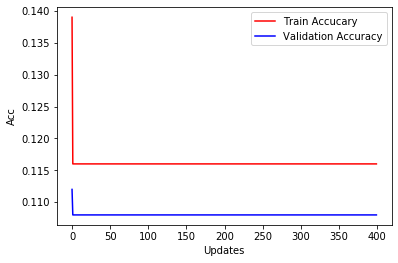

In [16]:
net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.Adam(net.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())
training_loop(optimizer,400)

Clearly does not work well. Let's try again, but with a lower learning rate.

torch.Size([45, 10])
Epoch  1 : Train Loss 0.214545 , Train acc 0.700000, Valid acc 0.646000
Epoch 51 : Train Loss 0.147562 , Train acc 0.986000, Valid acc 0.856000
Epoch 101 : Train Loss 0.147314 , Train acc 0.988000, Valid acc 0.846000
Epoch 151 : Train Loss 0.147298 , Train acc 0.988000, Valid acc 0.850000
Epoch 201 : Train Loss 0.147194 , Train acc 0.989000, Valid acc 0.854000
Epoch 251 : Train Loss 0.147193 , Train acc 0.989000, Valid acc 0.854000
Epoch 301 : Train Loss 0.147192 , Train acc 0.989000, Valid acc 0.854000
Epoch 351 : Train Loss 0.147190 , Train acc 0.989000, Valid acc 0.860000


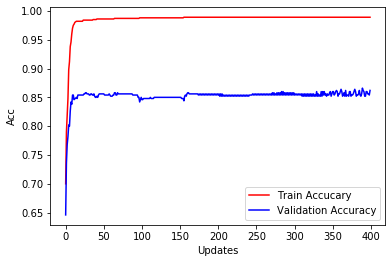

In [17]:
net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())
training_loop(optimizer,400)

Let's try the ADAM optimizer with an additional layer:

torch.Size([45, 1024])
Epoch  1 : Train Loss 0.683708 , Train acc 0.347000, Valid acc 0.316000
Epoch 51 : Train Loss 0.604796 , Train acc 0.886000, Valid acc 0.772000
Epoch 101 : Train Loss 0.601248 , Train acc 0.950000, Valid acc 0.822000
Epoch 151 : Train Loss 0.595128 , Train acc 0.982000, Valid acc 0.848000
Epoch 201 : Train Loss 0.595122 , Train acc 0.982000, Valid acc 0.846000
Epoch 251 : Train Loss 0.595119 , Train acc 0.982000, Valid acc 0.846000
Epoch 301 : Train Loss 0.595018 , Train acc 0.983000, Valid acc 0.850000
Epoch 351 : Train Loss 0.595017 , Train acc 0.983000, Valid acc 0.848000


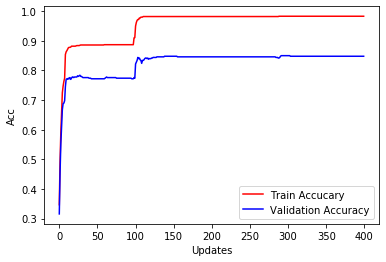

In [20]:
net = Net_3(num_features, num_l1, 1024, num_classes,'none')
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())
training_loop(optimizer,400)

Where we can see faster convergence(in terms of epochs) as compared to the stochastic gradient method, where before it only converged to around 30% accuracy in the same amount of epochs(Do note that the learning rates are not equal).


Now we will do some regularization. We will modify the training loop a little-bit to accomodate this

torch.Size([45, 10])
Epoch  1 : Train Loss 14.975883 , Train acc 0.084000, Valid acc 0.076000
Epoch 51 : Train Loss 0.279680 , Train acc 0.092000, Valid acc 0.088000
Epoch 101 : Train Loss 0.279599 , Train acc 0.117000, Valid acc 0.104000
Epoch 151 : Train Loss 0.279438 , Train acc 0.087000, Valid acc 0.108000
Epoch 201 : Train Loss 0.279268 , Train acc 0.087000, Valid acc 0.108000
Epoch 251 : Train Loss 0.279295 , Train acc 0.087000, Valid acc 0.108000
Epoch 301 : Train Loss 0.279124 , Train acc 0.105000, Valid acc 0.092000
Epoch 351 : Train Loss 0.279015 , Train acc 0.094000, Valid acc 0.102000


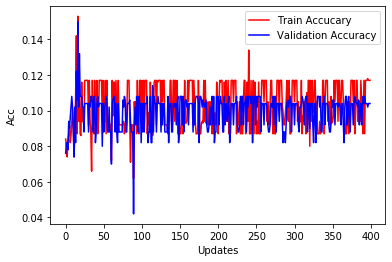

In [43]:
def training_loop_loss(optimizer,num_epochs,l1,l2):
# setting hyperparameters and gettings epoch sizes
    batch_size = 100
    num_samples_train = x_train.shape[0]
    num_batches_train = num_samples_train // batch_size
    num_samples_valid = x_valid.shape[0]
    num_batches_valid = num_samples_valid // batch_size

    # setting up lists for handling loss/accuracy
    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    test_acc, test_loss = [], []
    cur_loss = 0
    losses = []
    get_slice = lambda i, size: range(i * size, (i + 1) * size)

    for epoch in range(num_epochs):
        # Forward -> Backprob -> Update params
        ## Train
        cur_loss = 0
        net.train()
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_train[slce]))
            output = net(x_batch)

            # compute gradients given loss
            target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
            batch_loss = criterion(output, target_batch)
            l1_regularization, l2_regularization = 0,0
            for param in net.parameters():
                l1_regularization += torch.norm(param, 1)
                l2_regularization += torch.norm(param, 2)
            batch_loss += l1* l1_regularization + l2 *l2_regularization
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            cur_loss += batch_loss   
            losses.append(cur_loss / batch_size)

        net.eval()
        ### Evaluate training
        train_preds, train_targs = [], []
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_train[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]

            train_targs += list(targets_train[slce])
            train_preds += list(preds.data.numpy())

        ### Evaluate validation
        val_preds, val_targs = [], []
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]
            val_preds += list(preds.data.numpy())
            val_targs += list(targets_valid[slce])

        train_acc_cur = accuracy_score(train_targs, train_preds)
        valid_acc_cur = accuracy_score(val_targs, val_preds)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)

        if epoch % 50 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                    epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

    epoch = np.arange(len(train_acc))
    plt.figure()
    plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('Updates'), plt.ylabel('Acc')
net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())
training_loop_loss(optimizer,400,0.01,0)

Epoch  1 : Train Loss 0.230273 , Train acc 0.117000, Valid acc 0.104000
Epoch 51 : Train Loss 0.229865 , Train acc 0.312000, Valid acc 0.288000
Epoch 101 : Train Loss 0.183251 , Train acc 0.665000, Valid acc 0.626000
Epoch 151 : Train Loss 0.157360 , Train acc 0.926000, Valid acc 0.810000
Epoch 201 : Train Loss 0.152160 , Train acc 0.959000, Valid acc 0.822000
Epoch 251 : Train Loss 0.150259 , Train acc 0.969000, Valid acc 0.816000
Epoch 301 : Train Loss 0.149746 , Train acc 0.970000, Valid acc 0.824000
Epoch 351 : Train Loss 0.149579 , Train acc 0.970000, Valid acc 0.820000


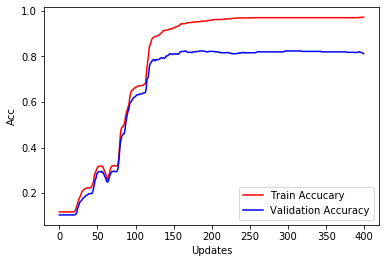

In [44]:
training_loop_loss(optimizer,400,0.0001*10**(-2),0)

Epoch  1 : Train Loss 0.212971 , Train acc 0.653000, Valid acc 0.614000
Epoch 51 : Train Loss 0.147652 , Train acc 0.989000, Valid acc 0.862000
Epoch 101 : Train Loss 0.147478 , Train acc 0.990000, Valid acc 0.868000
Epoch 151 : Train Loss 0.147350 , Train acc 0.991000, Valid acc 0.866000
Epoch 201 : Train Loss 0.147330 , Train acc 0.991000, Valid acc 0.864000
Epoch 251 : Train Loss 0.147313 , Train acc 0.991000, Valid acc 0.864000
Epoch 301 : Train Loss 0.147295 , Train acc 0.991000, Valid acc 0.860000
Epoch 351 : Train Loss 0.147278 , Train acc 0.991000, Valid acc 0.868000


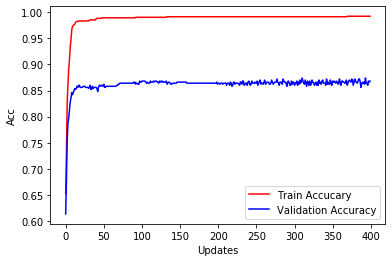

In [48]:
net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.Adam(net.parameters(), lr=0.001)
training_loop_loss(optimizer,400,0,0.0001)

Epoch  1 : Train Loss 0.199673 , Train acc 0.702000, Valid acc 0.632000
Epoch 51 : Train Loss 0.151198 , Train acc 0.985000, Valid acc 0.856000
Epoch 101 : Train Loss 0.151837 , Train acc 0.987000, Valid acc 0.852000
Epoch 151 : Train Loss 0.152737 , Train acc 0.989000, Valid acc 0.876000
Epoch 201 : Train Loss 0.149671 , Train acc 0.992000, Valid acc 0.864000
Epoch 251 : Train Loss 0.149376 , Train acc 0.992000, Valid acc 0.868000
Epoch 301 : Train Loss 0.151473 , Train acc 0.992000, Valid acc 0.872000
Epoch 351 : Train Loss 0.148875 , Train acc 0.993000, Valid acc 0.872000


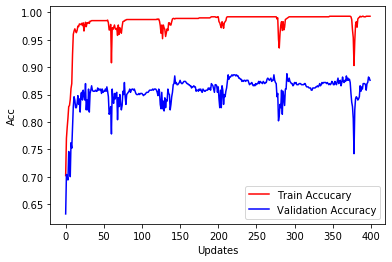

In [54]:
net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.Adam(net.parameters(), lr=0.01)
training_loop_loss(optimizer,400,0,0.001)

Let us try using a dropout scheme, by dropping out some of the nodes in the activation function for the 1 layer model:

In [62]:
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output,weightinit):
        super(Net, self).__init__()  
        # input layer
        if(weightinit == 'xavier'):
            self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        else:
            self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        self.activation = torch.nn.ELU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.dropout(self.activation(x))
        x = F.linear(x, self.W_2, self.b_2)
        return F.softmax(x, dim=1)


net = Net(num_features, num_l1, num_classes,'none')

Which gives a decent validation error of around 90%. Using the dropout gives the very jagged look of the accuracy function.

Epoch  1 : Train Loss 0.200139 , Train acc 0.650000, Valid acc 0.596000
Epoch 51 : Train Loss 0.149957 , Train acc 0.935000, Valid acc 0.804000
Epoch 101 : Train Loss 0.148527 , Train acc 0.977000, Valid acc 0.834000
Epoch 151 : Train Loss 0.148695 , Train acc 0.974000, Valid acc 0.846000
Epoch 201 : Train Loss 0.149007 , Train acc 0.977000, Valid acc 0.874000
Epoch 251 : Train Loss 0.148918 , Train acc 0.971000, Valid acc 0.836000
Epoch 301 : Train Loss 0.149509 , Train acc 0.966000, Valid acc 0.834000
Epoch 351 : Train Loss 0.149919 , Train acc 0.968000, Valid acc 0.872000
Epoch 401 : Train Loss 0.148592 , Train acc 0.982000, Valid acc 0.872000
Epoch 451 : Train Loss 0.148310 , Train acc 0.983000, Valid acc 0.874000
Epoch 501 : Train Loss 0.148035 , Train acc 0.984000, Valid acc 0.878000
Epoch 551 : Train Loss 0.148115 , Train acc 0.982000, Valid acc 0.852000
Epoch 601 : Train Loss 0.148183 , Train acc 0.984000, Valid acc 0.866000
Epoch 651 : Train Loss 0.148006 , Train acc 0.984000,

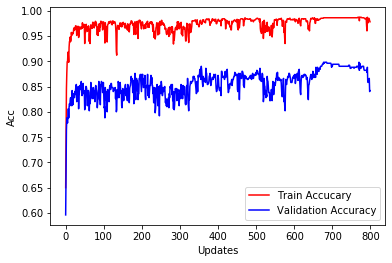

In [64]:
net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.Adam(net.parameters(), lr=0.01)
training_loop_loss(optimizer,800,0,0)

Epoch  1 : Train Loss 0.179598 , Train acc 0.731000, Valid acc 0.674000
Epoch 51 : Train Loss 0.147698 , Train acc 0.984000, Valid acc 0.854000
Epoch 101 : Train Loss 0.148525 , Train acc 0.978000, Valid acc 0.848000
Epoch 151 : Train Loss 0.147702 , Train acc 0.984000, Valid acc 0.856000
Epoch 201 : Train Loss 0.147705 , Train acc 0.984000, Valid acc 0.856000
Epoch 251 : Train Loss 0.147615 , Train acc 0.985000, Valid acc 0.848000
Epoch 301 : Train Loss 0.147615 , Train acc 0.985000, Valid acc 0.852000
Epoch 351 : Train Loss 0.147615 , Train acc 0.985000, Valid acc 0.852000
Epoch 401 : Train Loss 0.147615 , Train acc 0.985000, Valid acc 0.852000
Epoch 451 : Train Loss 0.147615 , Train acc 0.985000, Valid acc 0.854000
Epoch 501 : Train Loss 0.147615 , Train acc 0.985000, Valid acc 0.852000
Epoch 551 : Train Loss 0.147615 , Train acc 0.985000, Valid acc 0.852000
Epoch 601 : Train Loss 0.147615 , Train acc 0.985000, Valid acc 0.854000
Epoch 651 : Train Loss 0.147615 , Train acc 0.985000,

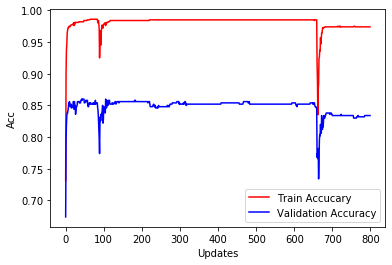

In [76]:
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output,weightinit):
        super(Net, self).__init__()  
        # input layer
        if(weightinit == 'xavier'):
            self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        else:
            self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        self.activation = torch.nn.ELU()
        self.dropout = nn.Dropout(p=0.2)
        self.batch = nn.BatchNorm1d((num_hidden))

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.batch(self.activation(x))
        x = F.linear(x, self.W_2, self.b_2)
        return F.softmax(x, dim=1)


net = Net(num_features, num_l1, num_classes,'none')
optimizer = optim.Adam(net.parameters(), lr=0.01)
training_loop_loss(optimizer,800,0,0)

We also test the model using three layers

Epoch  1 : Train Loss 0.691736 , Train acc 0.162000, Valid acc 0.140000
Epoch 51 : Train Loss 0.596487 , Train acc 0.972000, Valid acc 0.866000
Epoch 101 : Train Loss 0.596052 , Train acc 0.975000, Valid acc 0.854000
Epoch 151 : Train Loss 0.595955 , Train acc 0.976000, Valid acc 0.856000
Epoch 201 : Train Loss 0.595004 , Train acc 0.987000, Valid acc 0.872000
Epoch 251 : Train Loss 0.594906 , Train acc 0.987000, Valid acc 0.864000
Epoch 301 : Train Loss 0.594870 , Train acc 0.986000, Valid acc 0.858000
Epoch 351 : Train Loss 0.594850 , Train acc 0.986000, Valid acc 0.856000


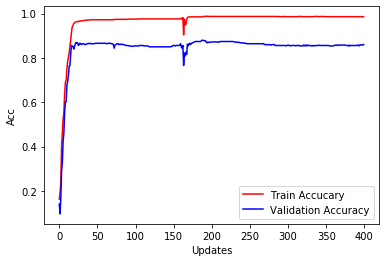

In [82]:
# Using three layers

#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net_3(nn.Module):

    def __init__(self, num_features, num_hidden,num_hidden_2, num_output,weightinit):
        super(Net_3, self).__init__()  
        # input layer
        if(weightinit == 'xavier'):
            self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        else:
            self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features)))
            self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
            self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden_2, num_hidden)))
            self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden_2), 0))
            self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden_2)))
            self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
            
        self.activation = torch.nn.ELU()
        self.dropout = nn.Dropout(p=0.2)
        self.batch1 = nn.BatchNorm1d((num_hidden))
        self.batch2 = nn.BatchNorm1d(num_hidden_2)

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.batch1(self.activation(x))
        x = F.linear(x, self.W_2, self.b_2)
        x = self.batch2(self.activation(x))
        F.linear(x,self.W_3,self.b_3)
        return F.softmax(x, dim=1)
    
net = Net_3(num_features, num_l1, 1024, num_classes,'none')
#Test the forward pass with dummy data
optimizer = optim.Adam(net.parameters(), lr=0.01)
training_loop(optimizer,400)

Using the batch normalization of the activation function gives a slightly higher validation accuracy, although this might not be the case for running the model with different initial conditions. In general we could have probably improved the results by doing a grid search for the hyperparameters

We will do the first exercise of Michael's book, in chapter one. Consider the perceptron defined as:
\begin{eqnarray}
  \mbox{output} = \left\{ 
    \begin{array}{ll} 
      0 & \mbox{if } w\cdot x + b \leq 0 \\
      1 & \mbox{if } w\cdot x + b > 0
    \end{array}
  \right.
\tag{2}\end{eqnarray}
Will the output change if we scale the parameters by a positive scalar, c? Simply rewriting it and multiplying by c on both sides we get:
\begin{eqnarray}
  \mbox{output} = \left\{ 
    \begin{array}{ll} 
  0 & \mbox{if } w\cdot c \cdot  x  \leq -b \cdot c \\
      1 & \mbox{if } w\cdot c \cdot x  > -b \cdot c
         \end{array}
  \right.
\tag{2}\end{eqnarray}

Thus the behavior does not change if c is positive, since we can divide it out, and get the original formulation.
Since the input-output relation of each perceptron in a network stays the same, the total behavior of the system stays the same.

We then consider part 2.

The definition of the sigmoid is:
\begin{eqnarray} 
  \frac{1}{1+\exp(-\sum_j w_j x_j-b)}.
\tag{4}\end{eqnarray}

Now we can multiply a c on each term and take it out of the sum, so we get
\begin{eqnarray} 
  \frac{1}{1+\exp(-\sum_j  c w_j x_j- c b)}.
\tag{4} = \end{eqnarray}
\begin{eqnarray} 
  \frac{1}{1+\exp(-c (\sum_j w_j x_j-b))}.
\tag{4} 
\end{eqnarray}

We then have  


\begin{equation}
    \lim_{c\to \infty}  \frac{1}{1+\exp(-c (\sum_j w_j x_j-b))} = \left\{\begin{array}{lr}
        1, & \text{for } \sum_j w_j x_j-b > 0 \\
        \frac{1}{2}, & \text{for } \sum_j w_j x_j-b = 0 \\
        0 , & \text{for } \sum_j w_j x_j-b < 0
        \end{array}\right\}
\end{equation}

This means that the sigmoid functions acts like a perceptron in the limit, given $\sum_j w_j x_j-b \neq 0$. And that the network will act equivalent to a perceptron network, under the condition that no input to the sigmoid function is zero.